# Predicting Scalar Coupling constant

The goal of this competition is to predict the scalar coupling constant between atoms in a given molecule.

You are given: 
- Atom types(elements)
- Coupling type
- 3d structure, given in XYZ coordinates

Files provided:
- train, gives the atom information
- test, testing data
- structures, the 3d structures

Extra files(will NOT be given during the actual scoring)
- dipole moments
- magnetic shielding tensors
- mulliken charges
- potential energy
- scalar coupling contributions

First, just import libraries

In [2]:
# standard libraries for data wrangling & visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning libraries
import tensorflow as tf
from keras.layers import Dense, Input, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model

# other libraries
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.


#### Importing
Import all the data as data frames and then (optionally) reduce the memory usage for better performance

This can take a while depending on the performance of your machine

In [3]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df_struct = pd.read_csv('input/structures.csv')

df_potential = pd.read_csv('input/potential_energy.csv')
df_dipole = pd.read_csv('input/dipole_moments.csv')
df_mulliken = pd.read_csv('input/mulliken_charges.csv')
df_magnetic = pd.read_csv('input/magnetic_shielding_tensors.csv')

df_scc = pd.read_csv('input/scalar_coupling_contributions.csv')

In [4]:
# reduce_mem_usage taken from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_struct = reduce_mem_usage(df_struct)

df_potential = reduce_mem_usage(df_potential)
df_dipole = reduce_mem_usage(df_dipole)
df_mulliken = reduce_mem_usage(df_mulliken)
df_magnetic = reduce_mem_usage(df_magnetic)

df_scc = reduce_mem_usage(df_scc)

Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)


Be wary that the memory reduction does reduce the accuracy of the data so be sure to keep looking at the original

Now lets look at some of the data

In [40]:
df_train[['type', 'scalar_coupling_constant']].head(20)

,type,scalar_coupling_constant
0,1JHC,84.812500
1,2JHH,-11.257812
2,2JHH,-11.257812
3,2JHH,-11.257812
4,1JHC,84.812500
5,2JHH,-11.257812
6,2JHH,-11.257812
7,1JHC,84.812500
8,2JHH,-11.257812
9,1JHC,84.812500


At first glance, it seems that the type plays a big role in determining the scalar coupling constant. Looking at other public kernels, it seems like creating a model for each type is the best performance

Let's try looking at the distribution for each of the types

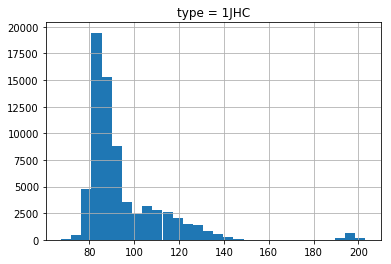

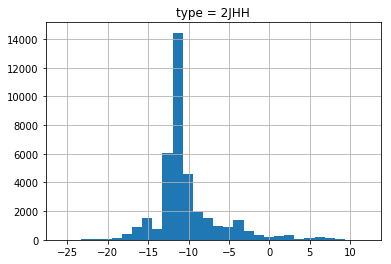

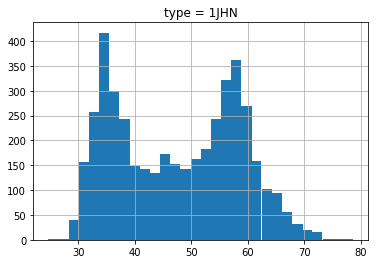

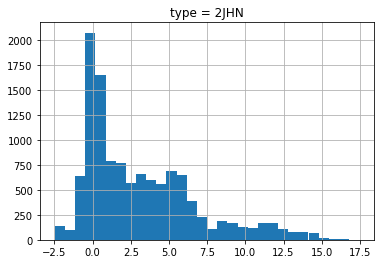

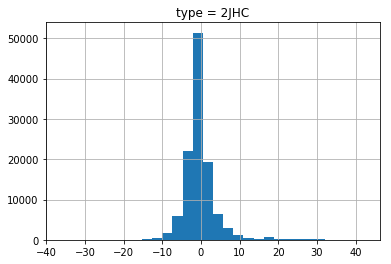

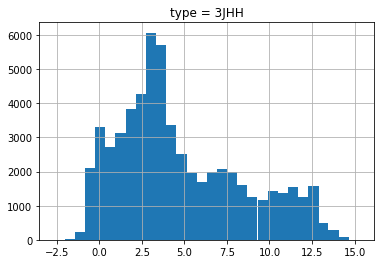

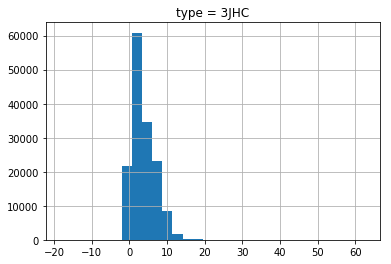

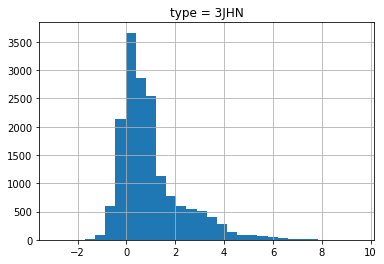

In [120]:
types = df_train['type'].unique()
for i in range(df_train['type'].nunique()):
    t = types[i]
    plt.title(f'type = {t}')
    plt.show(df_train['scalar_coupling_constant'][(df_train.type == t)][::10].hist(bins=30))
    

Each type has quite a different distribution, so custom models would be the best, afterall the test data DOES provide the coupling type

### Feature engineering and selection
The given data is pretty sparse and only provides 3d information and the type of atom
With the given 3d information, it is possible to calculate the distance between the two atoms which seems promising.

In [45]:
# taken from https://www.kaggle.com/inversion/atomic-distance-benchmark/output

def map_atom_info(df, atom_idx):
    df = pd.merge(df, df_struct, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

for i in [0,1]:
    df_train = map_atom_info(df_train,i)
    df_test = map_atom_info(df_test,i)

In [50]:
# modified from https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark
# who uses vectorized(i think?) calculations

def map_dists(df):
    p_0 = df[['x_0', 'y_0', 'z_0']].values
    p_1 = df[['x_1', 'y_1', 'z_1']].values
    df['dist'] = np.linalg.norm(p_0 - p_1, axis=1)
    
map_dists(df_train)
map_dists(df_test)

df_train.head(10)


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465,1.782227
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250,1.783203
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003,1.091797
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.541016,1.447266,-0.876465,1.783203
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.523926,1.437500,0.906250,1.782227
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,C,-0.012695,1.085938,0.008003,1.091797
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,H,-0.541016,1.447266,-0.876465,H,-0.523926,1.437500,0.906250,1.783203
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,C,-0.012695,1.085938,0.008003,1.091797


I'm still debating on whether to include the position for the final model, as that is *technically* relative

On another note, since we are dealing with bonds, one important factor in deciding bond strength is electronegativity and more importantly the *difference* in electronegativities, as that determines the favorability of bonds.

I also want to let the algorithm know if it is the same atom so hopefully it decreases the importance of the difference(because it would be zero)

In [69]:
# im using the electronegativities from https://en.wikipedia.org/wiki/Electronegativity

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04}

def add_electronegativity(df):
    for i in [0,1]:
        df[f'en_{i}'] = [electronegativity[x] for x in df[f'atom_{i}']]
    df['same_atom'] = (df['atom_1'] == 'H').apply(lambda x: 1 if x else 0)

In [119]:
add_electronegativity(df_train)
add_electronegativity(df_test)

df_train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,en_0,en_1,same_atom
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797,2.2,2.55,0
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203,2.2,2.20,1
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465,1.782227,2.2,2.20,1
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250,1.783203,2.2,2.20,1
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003,1.091797,2.2,2.55,0


Now that we have the distance and electronegativity, lets look up what j-coupling *actually is*

From https://en.wikipedia.org/wiki/J-coupling:
>In nuclear chemistry and nuclear physics, Scalar or J-couplings (also called indirect dipole–dipole coupling) are mediated through chemical bonds connecting two spins. It is an indirect interaction between two nuclear spins which arises from hyperfine interactions between the nuclei and local electrons.In NMR spectroscopy J-coupling contains information about relative bond distances and angles. Most importantly, J-coupling provides information on the connectivity of chemical bonds. It is responsible for the often complex splitting of resonance lines in the NMR spectra of fairly simple molecules.

Wikipedia mentions that dipoles, and interactions between nuclei and local electrons are important to j-coupling. It also mentions that it has information about relative bond distances and angles.

We have dipoles of the whole molecule, but not between two atoms(which is what the wiki is talking about). I think that these dipoles can be calculated by giving the electronegativity of the closest atom for BOTH of the atoms. This might be helpful for the 3J couplings as there are two atoms in between so their interactions might be important. I'll tackle this later

Interactions between nuclei and local electrons also are important. This data is somewhat in electronegativity, but we can also add electron affinity and first ionization energy.

The bond distances and angles can be taken from the XYZ information and the "relativeness" can be given by providing the mean and std. deviation within the molecule. The wikipedia page also mentions the Karplus equation which mentions that the coupling depends on the dihedral angle(cos(phi) and cos(2pi)), but dihedral angles are only relavent for J=3